In [76]:
import openmc
import openmc.data as data
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Helper Functions

In [100]:
def at2wt(*args):
    wt_dict = {}
    for iso, at in args:
        mass = data.atomic_mass(iso)
        wt_dict[iso] = at * mass
        
    denom = sum(wt_dict.values())
    
    for iso in wt_dict.keys():
        wt_dict[iso] /= denom
    return wt_dict 

def alpha(T):
    return -0.4247 + 1.282e-3 * T + 7.362e-7 * T**2 - 2.069e-10 * T**3

def density(T, rho0, t0 = 25):
    differential = T - t0
    return rho0 / (1 + 3 * alpha(T) * differential)

def fuel_density(T):
    U_rho = 19360 - 1.03347 * T
    Zr_rho = 6550 - 0.1685 * T
    atZr = .2245
    return atZr * Zr_rho + (1-atZr) * U_rho

def sodium_density(T):
    temps = np.array([126.85, 226.85, 326.85, 426.85, 526.85, 626.85, 726.85])
    rhos = np.array([919, 897, 874, 852, 828, 805, 781])
    rho_func = scp.interpolate.interp1d(temps,rhos)
    return np.float64(rho_func(T))

# Materials

In [105]:
def fuel(at, suffix='',temp = 507.5):
    
    u235 = ('U235', at)
    u238 = ('U238', 1-at)
    wt = at2wt(u235, u238)['U235']
    
    mat = openmc.Material(name=f'fuel_{suffix}', temperature=temp)
    
    mat.add_element('Zr', .1, 'wo')
    mat.add_nuclide('U235', 0.9*wt, 'wo')
    mat.add_nuclide('U238', 0.9*(1-wt), 'wo')
    mat.set_density('kg/m3', fuel_density(temp))
    return mat

def sodium(temp, name):
    mat = openmc.Material(name=name, temperature=temp)
    
    mat.add_element('Na', 1.0)
    mat.set_density('kg/m3', sodium_density(temp))
    return mat

def cladding(temp):
    mat = openmc.Material(name='cladding', temperature=temp)
    
    mat.add_element('Fe', 85.007, 'wo')
    mat.add_element('Cr', 11.79 , 'wo')
    mat.add_element('Mo', 0.99  , 'wo')
    mat.add_element('Mn', 0.59  , 'wo')
    mat.add_element('Ni', 0.53  , 'wo')
    mat.add_element('W' , 0.45  , 'wo')
    mat.add_element('V' , 0.31  , 'wo')
    mat.add_element('C' , 0.19  , 'wo')
    mat.add_element('Si', 0.10  , 'wo')
    mat.add_element('Nb', 0.02  , 'wo')
    mat.add_element('P' , 0.019 , 'wo')
    mat.add_element('N' , 0.01  , 'wo')
    mat.add_element('S' , 0.004 , 'wo')

    rho0 = 7700.0
    mat.set_density('kg/m3', density(temp, rho0))
    return mat

def control_rod(temp):
    mat = openmc.Material(name='control_rod', temperature=temp)

    mat.add_elements_from_formula('C4B')

    rho0 = 2520
    mat.set_density('kg/m3', density(temp, rho0))
    return mat

In [107]:
inner_fuel = fuel(.109, 'inner')
middle_fuel = fuel(.124, 'middle')
outer_fuel = fuel(.155, 'outer')

bond = sodium(497.5, 'bond')
coolant = sodium(432.5, 'coolant')

clad = cladding(482.5)

cntrl_rod = control_rod(450.0) # dont know cr temp

MATERIALS = openmc.Materials([inner_fuel, middle_fuel, outer_fuel, bond, coolant, clad, cntrl_rod])

# Geometry

In [120]:
# PARAMETERS

# Core
core_height = 150.0
core_diameter = 277.6

# Assembly
inner_assembly_edge_length = 9.815
inner_assembly_diameter = 17.0

outer_assembly_edge_length = 9.915
outer_assembly_diameter = 17.173

assembly_pitch = 17.173
assembly_rings = 7

# Fuel Slugs
fuel_radius = 1.126 / 2

clad_inner_radius = 1.300 / 2
clad_outer_radius = 1.400 / 2

slug_pitch = 1.501

num_slugs_per_pitch = 127

In [210]:
def slug(where):

    fuel_fills = {'inner':inner_fuel, 'middle':middle_fuel, 'outer':outer_fuel}

    # Surfaces
    fuel_outer = openmc.ZCylinder(r=fuel_radius)
    clad_inner = openmc.ZCylinder(r=clad_inner_radius)
    clad_outer = openmc.ZCylinder(r=clad_outer_radius)

    # Fuel Cell
    fuel_cell = openmc.Cell(name='Fuel')
    fuel_cell.region = -fuel_outer
    fuel_cell.fill = fuel_fills[where]

    # Bond Cell
    bond_cell = openmc.Cell(name='Bond')
    bond_cell.region = +fuel_outer & -clad_inner
    bond_cell.fill = bond

    # Clad Cell
    clad_cell = openmc.Cell(name='Clad')
    clad_cell.region = +clad_inner & -clad_outer
    clad_cell.fill = clad

    # Coolant Cell
    coolant_cell = openmc.Cell(name='Coolant')
    coolant_cell.region = +clad_outer
    coolant_cell.fill = coolant

    universe = openmc.Universe(name = 'Slug Universe', cells = [fuel_cell, bond_cell, clad_cell, coolant_cell])

    return universe

def assembly(fill_universe, pitch, num_rings):
    
    # Lattice
        # Universe fills
    universes_per_ring = [ring * (num_rings-1) for ring in list(range(num_rings-1,0, -1))] + [1]
    lattie_universes =[[fill_universe]*num for num in number_per_ring]
        # Lattice definition
    lattice = openmc.HexLattice()
    lattice.pitch = (pitch,)
    lattice.center = (0.0, 0.0) 
    lattice.outer = openmc.Universe(cells=[openmc.Cell(fill=coolant)])
    lattice.universes = lattie_universes

    # Assembly
    assembly_clad_inner = openmc.model.HexagonalPrism(edge_length=inner_assembly_edge_length)
    assembly_clad_outer = openmc.model.HexagonalPrism(edge_length=outer_assembly_edge_length)
    
    assembly_slugs_cell = openmc.Cell(fill = lattice, region=-assembly_clad_inner)
    assembly_clad_cell = openmc.Cell(fill = clad, region = +assembly_clad_inner & -assembly_clad_outer)
    universe = openmc.Universe(cells=[inner_hex_cell, outer_hex_cell])
    
    return universe

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

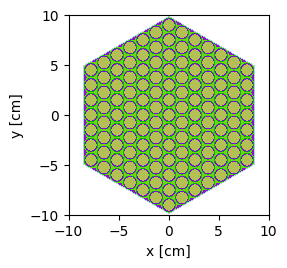

In [214]:
fuel_assembly = assembly(slug('inner'), slug_pitch, assembly_rings)
fuel_assembly.plot(width=(20,20))